In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy

In [2]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [97]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [4]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_7.csv'
raw_data = readCsv(file_path)

In [85]:
print(raw_data.shape)

(4, 3072000)


In [86]:
# reshape(,FRAME_COUNT,SAMPLE_PER_FRAME)SAMPLE_PER_CHIRP
data_channel=raw_data[0]
single_chirp_data =np.array([data_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)])
double_chirp_data =np.array([data_channel[SAMPLE_PER_FRAME*i:SAMPLE_PER_FRAME*(i+1)]for i in range(0,FRAME_COUNT)])
print(single_chirp_data.shape)
print(double_chirp_data.shape)

(6000, 256)
(6000, 512)


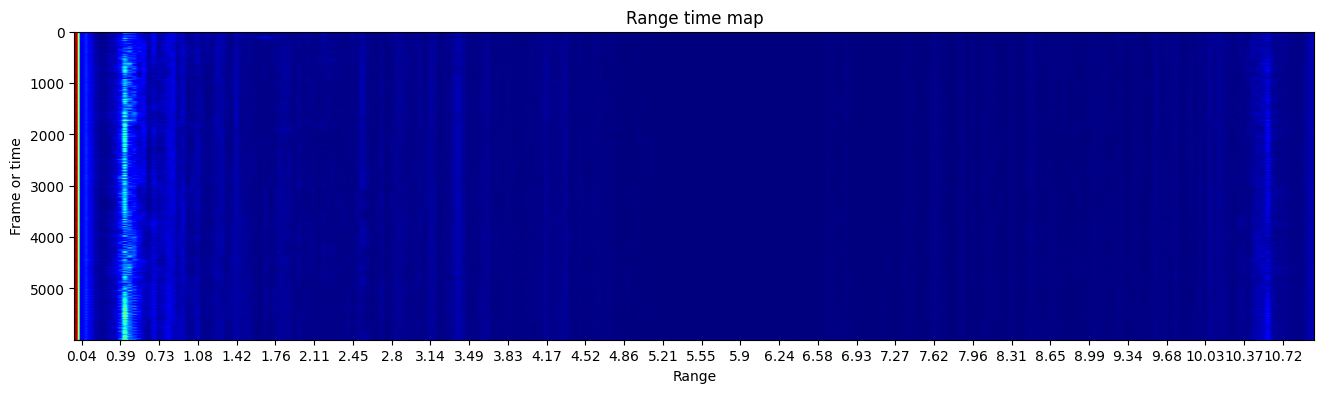

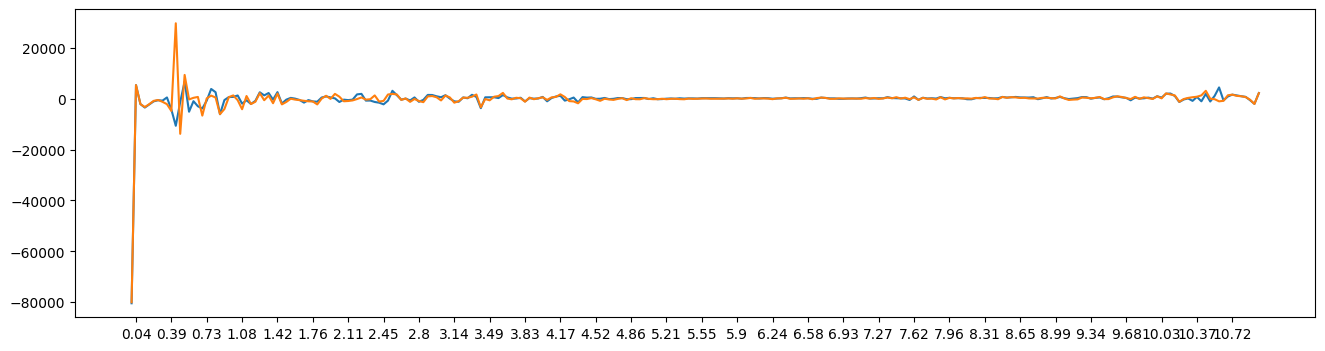

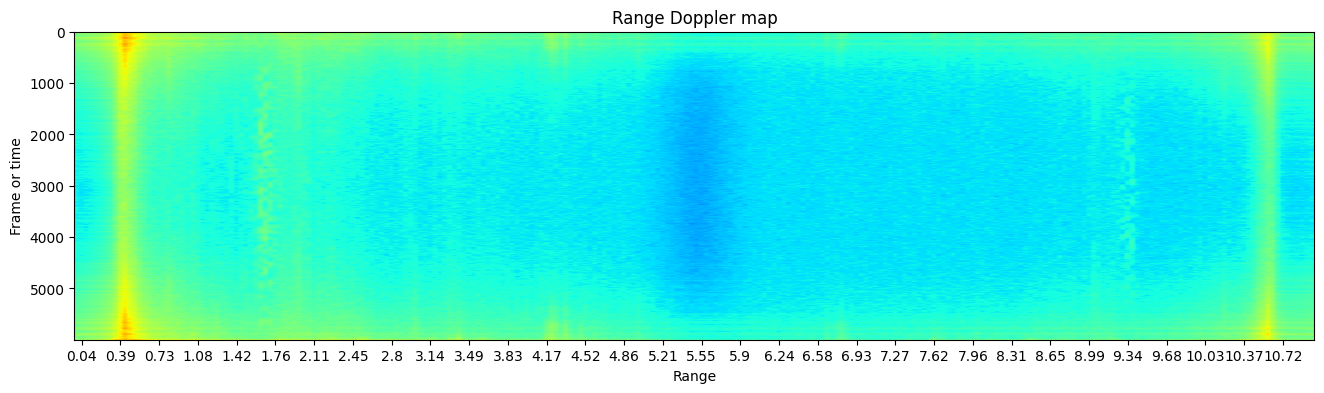

In [101]:
est_channel=single_chirp_data
range_for_plotting =range(1,FFT_SIZE,2**3)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

range_time_matrix=np.fft.fft(est_channel,axis=1)
range_doppler_matrix=np.fft.fft2(est_channel)

mag_range_time_matrix=np.abs(range_time_matrix)
mag_range_doppler_matrix=np.abs(range_doppler_matrix)

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range time map")
plt.imshow(mag_range_time_matrix,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(range_time_matrix[0])
plt.plot(range_time_matrix[-1])
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

column=range_time_matrix.shape[1]
colum_FFT_range_fft_channel_0=np.zeros_like(range_time_matrix)
for c in range(0,column):
    colum_FFT_range_fft_channel_0[:,c] =np.fft.fft(range_time_matrix[:,c])

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range Doppler map")
plt.imshow(np.log(np.abs(colum_FFT_range_fft_channel_0)),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()


In [102]:
#calculate the peak index on each chirp
def get_the_peaks(magnitude_matrix):
    print("shape of input: {0}".format(magnitude_matrix.shape))
    peak_indices=[]
    rows =range(0,magnitude_matrix.shape[0])
    for r in rows:
        peak_index = np.argmax(magnitude_matrix[r,1:])+1
        peak_indices.append(peak_index)
    return peak_indices

In [104]:
peaks = get_the_peaks(mag_range_time_matrix)
counts = np.bincount(peaks)
dominant_bin_index =np.argmax(counts)
print("dominant bin {0} respect to distance {2}m with count {1}".format(dominant_bin_index,counts[dominant_bin_index],dominant_bin_index*RANGE_BIN))

shape of input: (6000, 256)
dominant bin 10 respect to distance 0.4303617205204089m with count 4143


In [105]:
def extract_phase_DACM(complex_signals):
    phases=[]
    phases.append(np.angle(complex_signals[0]))

    for s in range(1,len(complex_signals)):
        phase_s=0
        for k in range(1,s):
            I_k =complex_signals[k].real
            Q_k=complex_signals[k].imag
            I_k_1=complex_signals[k-1].real
            Q_k_1=complex_signals[k-1].imag
            phase_s+=(I_k*(Q_k-Q_k_1) - (I_k -I_k_1)*Q_k)/(I_k**2 +Q_k**2)
        phases.append(phase_s)
    return phases


In [107]:
signal_fixed_bin =est_channel[:,dominant_bin_index]
signal_peak_bin=[]
rows =range(0,est_channel.shape[0])
colums =range(0,est_channel.shape[1])
for r in rows:
    peak_r =peaks[r]
    signal_peak_bin.append(est_channel[r,peak_r])

In [112]:
phase_unwrap_signal_fixed_bin=np.unwrap(np.angle(signal_fixed_bin))
phase_unwrap_signal_peak_bin=np.unwrap(np.angle(signal_peak_bin))
phase_DACM_signal_fixed_bin = extract_phase_DACM(signal_fixed_bin)
phase_DACM_signal_peak_bin = extract_phase_DACM(signal_peak_bin)


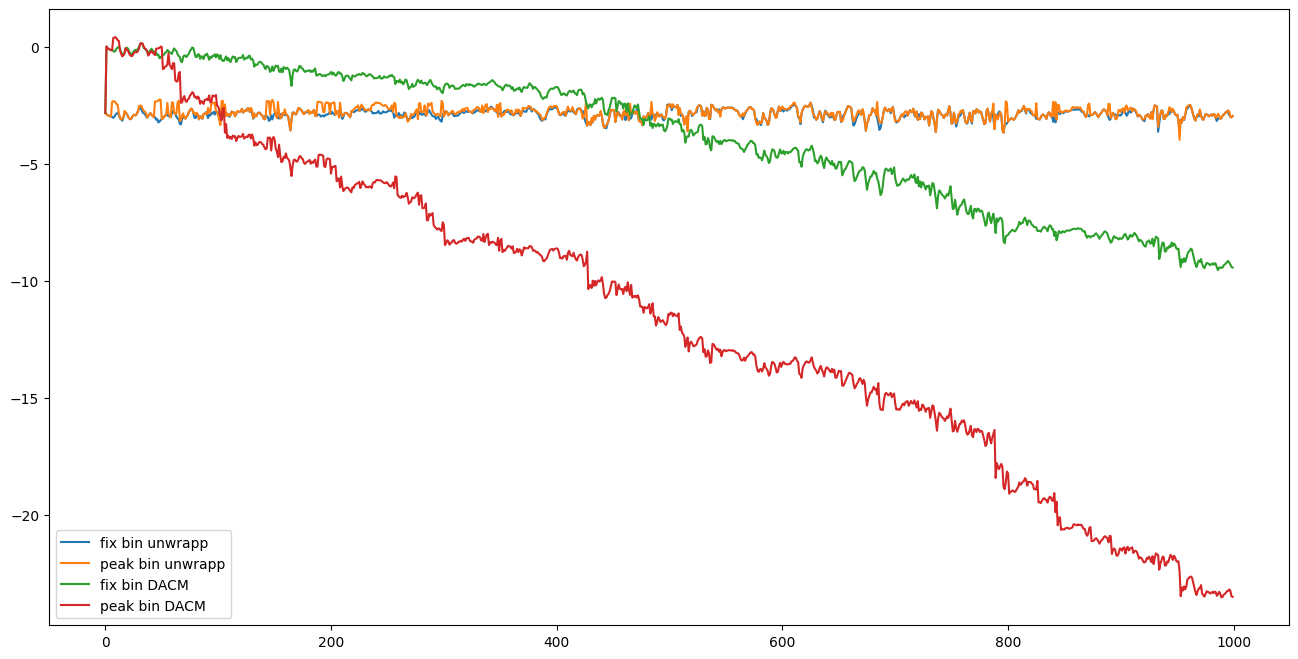

In [113]:
plt.figure(figsize=(16,8))
plt.plot(phase_unwrap_signal_fixed_bin[0:1000],label="fix bin unwrapp")
plt.plot(phase_unwrap_signal_peak_bin[0:1000],label="peak bin unwrapp")

plt.plot(phase_DACM_signal_fixed_bin[0:1000],label="fix bin DACM")
plt.plot(phase_DACM_signal_peak_bin[0:1000],label="peak bin DACM")
plt.legend()
plt.show()
